# Pre-req to run dragonnet

Fixing issues:   
```
brew install cmake
```

General issue:
```
pip install -U pip wheel setuptools pip-tools
```

Issue about lightbgm:
```
brew install libomp && pip install lightbgm
```
Issue about gast
```
pip install -U gast==0.3.3
```
Issue about seaborn
```
pip install seaborn
```
Issue about causalml
Please use 
```
conda install causalml
```
```
# For linux
pip install numpy==1.20.0

# For M1 Chip
pip3 install Cython
pip3 install --no-binary :all: --no-use-pep517 numpy
pip3 install pandas
pip3 install ib_insync

# install llvm
brew install llvm@11 && echo 'export PATH="/opt/homebrew/opt/llvm/bin:$PATH"' >> ~/.zshrc && export LDFLAGS="-L/opt/homebrew/opt/llvm/lib" && export CPPFLAGS="-I/opt/homebrew/opt/llvm/include"

pip install -U llvmlite<0.38.0 # https://pypi.org/project/llvmlite/

pip install -r -U Cython==0.28.0 scikit-learn==1.0.2

pip install duecredit
```

Tensorflow   
sklearn   
xgboost   
causalmltf   
Possible => PyTorch version, need some manual effort   

In [16]:
### AUUC
# sudo code:
# sort()
# x move 1/n, y up if p==p_hat 
# x move 1/n, y down if p!=p_hat
# calc area

In [17]:
### AUCC
# cost considered case: https://zhuanlan.zhihu.com/p/493811028

In [18]:
# AUUC could convert to loss as NDCG in some condition

In [19]:
# causalML: https://github.com/uber/causalml

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import causalml.inference

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.tf import DragonNet
from causalml.inference.meta import *
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

In [6]:
df = pd.read_csv(f'../../../test/data/ihdp_npci_3.csv', header=None)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f'x{i}' for i in range(1,26)]
df.columns = cols

In [7]:
print(df.shape)
df.head()

(747, 30)


,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.931652,3.500591,2.253801,7.136441,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,2.175966,5.952101,1.257592,6.553022,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.180294,7.175734,2.384100,7.192645,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,3.587662,7.787537,4.009365,7.712456,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,2.372618,5.461871,2.481631,7.232739,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [8]:
pd.Series(df['treatment']).value_counts(normalize=True)

0    0.813922
1    0.186078
Name: treatment, dtype: float64

In [9]:
X = df.loc[:,'x1':]
treatment = df['treatment']
y = df['y_factual']
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)

In [10]:
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,0,...,1,1,1,1,0,0,0,0,0,0
1,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,1,...,1,1,1,1,0,0,0,0,0,0
2,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,1,...,1,0,1,1,0,0,0,0,0,0
3,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
4,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,0,...,1,1,1,1,0,0,0,0,0,0


In [11]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

In [12]:
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2

from causalml.inference.tf.utils import (
    dragonnet_loss_binarycross,
    EpsilonLayer,
    regression_loss,
    binary_classification_loss,
    treatment_accuracy,
    track_epsilon,
    make_tarreg_loss,
)
from causalml.inference.meta.utils import convert_pd_to_np


class MyDragonNet:
    def __init__(
        self,
        neurons_per_layer=200,
        targeted_reg=True,
        ratio=1.0,
        val_split=0.2,
        batch_size=64,
        epochs=30,
        learning_rate=1e-3,
        reg_l2=0.01,
        loss_func=dragonnet_loss_binarycross,
        verbose=True,
    ):
        self.neurons_per_layer = neurons_per_layer
        self.targeted_reg = targeted_reg
        self.ratio = ratio
        self.val_split = val_split
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.loss_func = loss_func
        self.reg_l2 = reg_l2
        self.verbose = verbose

    def make_dragonnet(self, input_dim):
        inputs = Input(shape=(input_dim,), name="input")

        # representation
        x = Dense(
            units=self.neurons_per_layer,
            activation="elu",
            kernel_initializer="RandomNormal",
        )(inputs)
        x = Dense(
            units=self.neurons_per_layer,
            activation="elu",
            kernel_initializer="RandomNormal",
        )(x)
        x = Dense(
            units=self.neurons_per_layer,
            activation="elu",
            kernel_initializer="RandomNormal",
        )(x)

        t_predictions = Dense(units=1, activation="sigmoid")(x)

        # HYPOTHESIS
        y0_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(x)
        y1_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(x)

        # second layer
        y0_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(y0_hidden)
        y1_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(y1_hidden)

        # third
        y0_predictions = Dense(
            units=1,
            activation=None,
            kernel_regularizer=l2(self.reg_l2),
            name="y0_predictions",
        )(y0_hidden)
        y1_predictions = Dense(
            units=1,
            activation=None,
            kernel_regularizer=l2(self.reg_l2),
            name="y1_predictions",
        )(y1_hidden)

        dl = EpsilonLayer()
        epsilons = dl(t_predictions, name="epsilon")
        concat_pred = Concatenate(1)(
            [y0_predictions, y1_predictions, t_predictions, epsilons]
        )
        model = Model(inputs=inputs, outputs=concat_pred)

        return model

    def fit(self, X, treatment, y, p=None):
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        y = np.hstack((y.reshape(-1, 1), treatment.reshape(-1, 1)))

        self.dragonnet = self.make_dragonnet(X.shape[1])

        metrics = [
            regression_loss,
            binary_classification_loss,
            treatment_accuracy,
            track_epsilon,
        ]

        if self.targeted_reg:
            loss = make_tarreg_loss(ratio=self.ratio, dragonnet_loss=self.loss_func)
        else:
            loss = self.loss_func

        self.dragonnet.compile(
            optimizer=Adam(lr=self.learning_rate), loss=loss, metrics=metrics
        )

        adam_callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor="val_loss", patience=2, min_delta=0.0),
            ReduceLROnPlateau(
                monitor="loss",
                factor=0.5,
                patience=5,
                verbose=self.verbose,
                mode="auto",
                min_delta=1e-8,
                cooldown=0,
                min_lr=0,
            ),
        ]

        self.dragonnet.fit(
            X,
            y,
            callbacks=adam_callbacks,
            validation_split=self.val_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=10,
        )

        sgd_callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor="val_loss", patience=40, min_delta=0.0),
            ReduceLROnPlateau(
                monitor="loss",
                factor=0.5,
                patience=5,
                verbose=self.verbose,
                mode="auto",
                min_delta=0.0,
                cooldown=0,
                min_lr=0,
            ),
        ]

        sgd_lr = 1e-5
        momentum = 0.9
        self.dragonnet.compile(
            optimizer=SGD(lr=sgd_lr, momentum=momentum, nesterov=True),
            loss=loss,
            metrics=metrics,
        )
        self.dragonnet.fit(
            X,
            y,
            callbacks=sgd_callbacks,
            validation_split=self.val_split,
            epochs=300,
            batch_size=self.batch_size,
            verbose=self.verbose,
        )

    def predict(self, X, treatment=None, y=None, p=None):
        return self.dragonnet.predict(X)


    def predict_tau(self, X):
        preds = self.predict(X)
        return (preds[:, 1] - preds[:, 0]).reshape(-1, 1)
    
    def fit_predict(self, X, treatment, y, p=None, return_components=False):
        self.fit(X, treatment, y)
        return self.predict_tau(X)


In [13]:
dragon = MyDragonNet(neurons_per_layer=200, targeted_reg=True,verbose=10)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Metal device set to: Apple M1 Max


2023-03-19 00:00:38.250759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-19 00:00:38.250903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2023-03-19 00:00:38.661468: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-19 00:00:39.533602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-19 00:00:42.129179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 1/300


2023-03-19 00:00:44.873916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-19 00:00:46.193396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300

Epoch 16: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300

Epoch 28: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300

Epoch 40: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300

Epoch 45: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300

Epoch 5

2023-03-19 00:01:08.238427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 16ms/step


In [14]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          tau.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','tau','w','y']).T

df_cumgain = get_cumgain(df_preds)
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate, tau.mean()],
                     index=['S','T','X','R','dragonnet','actual'], columns=['ATE'])
df_result['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite, t_ite, x_ite, r_ite, dragon_ite],
                                                            [tau.values.reshape(-1,1)]*5 )
                ] + [None]
df_result['AUUC'] = auuc_score(df_preds)

In [15]:
df_result

,ATE,MAE,AUUC
S,4.054511,1.027666,0.575822
T,4.100199,0.980788,0.580929
X,4.020918,1.116303,0.564651
R,4.000777,1.709490,0.557411
dragonnet,4.027046,1.185699,0.554811
actual,4.098887,NaN,NaN


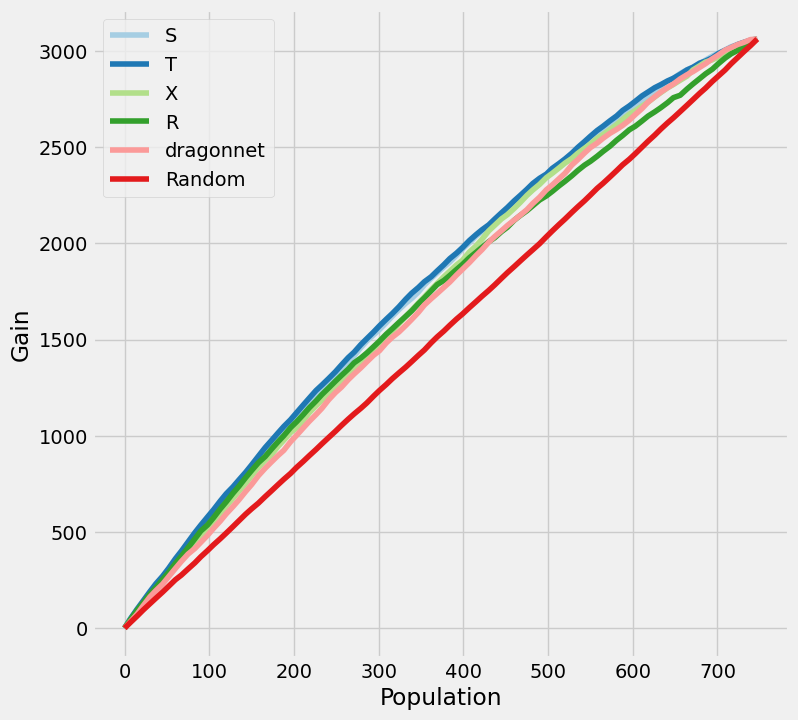

In [16]:
plot_gain(df_preds)

## causalml Synthetic Data Generation Method

In [17]:
y, X, w, tau, b, e = simulate_nuisance_and_easy_treatment(n=1000)

X_train, X_val, y_train, y_val, w_train, w_val, tau_train, tau_val, b_train, b_val, e_train, e_val = \
    train_test_split(X, y, w, tau, b, e, test_size=0.2, random_state=123, shuffle=True)

preds_dict_train = {}
preds_dict_valid = {}

preds_dict_train['Actuals'] = tau_train
preds_dict_valid['Actuals'] = tau_val

preds_dict_train['generated_data'] = {
    'y': y_train,
    'X': X_train,
    'w': w_train,
    'tau': tau_train,
    'b': b_train,
    'e': e_train}
preds_dict_valid['generated_data'] = {
    'y': y_val,
    'X': X_val,
    'w': w_val,
    'tau': tau_val,
    'b': b_val,
    'e': e_val}

# Predict p_hat because e would not be directly observed in real-life
p_model = ElasticNetPropensityModel()
p_hat_train = p_model.fit_predict(X_train, w_train)
p_hat_val = p_model.fit_predict(X_val, w_val)

for base_learner, label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],
                                 ['S', 'T', 'X', 'R']):
    for model, label_m in zip([LinearRegression, XGBRegressor], ['LR', 'XGB']):
        # RLearner will need to fit on the p_hat
        if label_l != 'R':
            learner = base_learner(model())
            # fit the model on training data only
            learner.fit(X=X_train, treatment=w_train, y=y_train)
            try:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, p=p_hat_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, p=p_hat_val).flatten()
            except TypeError:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, treatment=w_train, y=y_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, treatment=w_val, y=y_val).flatten()
        else:
            learner = base_learner(model())
            learner.fit(X=X_train, p=p_hat_train, treatment=w_train, y=y_train)
            preds_dict_train['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_train).flatten()
            preds_dict_valid['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_val).flatten()

learner = DragonNet(verbose=False)
learner.fit(X_train, treatment=w_train, y=y_train)
preds_dict_train['DragonNet'] = learner.predict_tau(X=X_train).flatten()
preds_dict_valid['DragonNet'] = learner.predict_tau(X=X_val).flatten()
actuals_train = preds_dict_train['Actuals']
actuals_validation = preds_dict_valid['Actuals']

synthetic_summary_train = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_train)] for label, preds
                                        in preds_dict_train.items() if 'generated' not in label.lower()},
                                       index=['ATE', 'MSE']).T
synthetic_summary_train['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_train['ATE']/synthetic_summary_train.loc['Actuals', 'ATE']) - 1)

synthetic_summary_validation = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_validation)]
                                             for label, preds in preds_dict_valid.items()
                                             if 'generated' not in label.lower()},
                                            index=['ATE', 'MSE']).T
synthetic_summary_validation['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_validation['ATE']/synthetic_summary_validation.loc['Actuals', 'ATE']) - 1)

# calculate kl divergence for training
for label in synthetic_summary_train.index:
    stacked_values = np.hstack((preds_dict_train[label], actuals_train))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_train[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_train, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_train.loc[label, 'KL Divergence'] = kl

# calculate kl divergence for validation
for label in synthetic_summary_validation.index:
    stacked_values = np.hstack((preds_dict_valid[label], actuals_validation))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_valid[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_validation, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_validation.loc[label, 'KL Divergence'] = kl
df_preds_train = pd.DataFrame([preds_dict_train['S Learner (LR)'].ravel(),
                               preds_dict_train['S Learner (XGB)'].ravel(),
                               preds_dict_train['T Learner (LR)'].ravel(),
                               preds_dict_train['T Learner (XGB)'].ravel(),
                               preds_dict_train['X Learner (LR)'].ravel(),
                               preds_dict_train['X Learner (XGB)'].ravel(),
                               preds_dict_train['R Learner (LR)'].ravel(),
                               preds_dict_train['R Learner (XGB)'].ravel(),                               
                               preds_dict_train['DragonNet'].ravel(),
                               preds_dict_train['generated_data']['tau'].ravel(),
                               preds_dict_train['generated_data']['w'].ravel(),
                               preds_dict_train['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'DragonNet','tau','w','y']).T

synthetic_summary_train['AUUC'] = auuc_score(df_preds_train).iloc[:-1]
df_preds_validation = pd.DataFrame([preds_dict_valid['S Learner (LR)'].ravel(),
                               preds_dict_valid['S Learner (XGB)'].ravel(),
                               preds_dict_valid['T Learner (LR)'].ravel(),
                               preds_dict_valid['T Learner (XGB)'].ravel(),
                               preds_dict_valid['X Learner (LR)'].ravel(),
                               preds_dict_valid['X Learner (XGB)'].ravel(),
                               preds_dict_valid['R Learner (LR)'].ravel(),
                               preds_dict_valid['R Learner (XGB)'].ravel(),                               
                               preds_dict_valid['DragonNet'].ravel(),
                               preds_dict_valid['generated_data']['tau'].ravel(),
                               preds_dict_valid['generated_data']['w'].ravel(),
                               preds_dict_valid['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'DragonNet','tau','w','y']).T

synthetic_summary_validation['AUUC'] = auuc_score(df_preds_validation).iloc[:-1]
synthetic_summary_train

2023-03-19 00:02:11.025968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-19 00:02:12.107837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-19 00:02:15.953725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-19 00:02:16.940506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/25 [===============>..............] - ETA: 0s

2023-03-19 00:02:28.804214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/7 [===>..........................] - ETA: 0s

2023-03-19 00:02:29.102805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 36ms/step


,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.484486,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.528743,0.044194,0.091349,3.473087,0.499758
S Learner (XGB),0.358208,0.310652,0.260643,0.817620,0.544115
T Learner (LR),0.493815,0.022688,0.019255,0.289978,0.610855
T Learner (XGB),0.397053,1.350928,0.180466,1.452143,0.521719
X Learner (LR),0.493815,0.022688,0.019255,0.289978,0.610855
X Learner (XGB),0.341352,0.620992,0.295435,1.086086,0.534827
R Learner (LR),0.457692,0.028116,0.055304,0.335083,0.614414
R Learner (XGB),0.434709,4.575591,0.102741,1.907325,0.505088
DragonNet,0.419995,0.031672,0.133112,0.382010,0.615552


In [18]:
synthetic_summary_validation

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.511242,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.528743,0.042236,0.034233,4.574498,0.496178
S Learner (XGB),0.434208,0.260496,0.150680,0.854890,0.544206
T Learner (LR),0.541503,0.025840,0.059191,0.686602,0.604712
T Learner (XGB),0.483404,0.679398,0.054452,1.215394,0.526918
X Learner (LR),0.541503,0.025840,0.059191,0.686602,0.604712
X Learner (XGB),0.330427,0.344865,0.353678,1.227041,0.536599
R Learner (LR),0.510236,0.030801,0.001967,0.654228,0.608133
R Learner (XGB),0.417823,1.990451,0.182730,1.650560,0.504991
DragonNet,0.467822,0.030379,0.084930,0.791592,0.609312


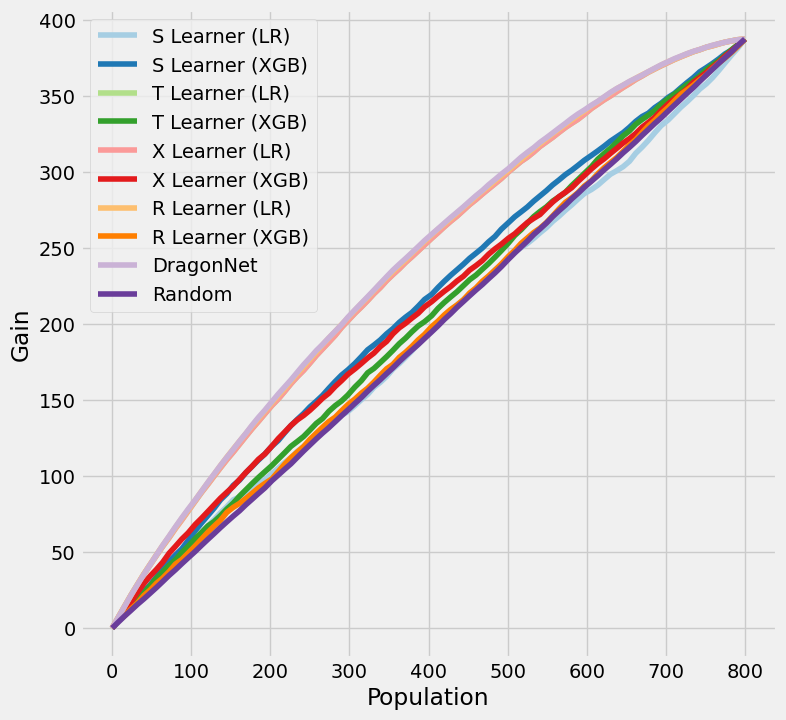

In [19]:
plot_gain(df_preds_train)

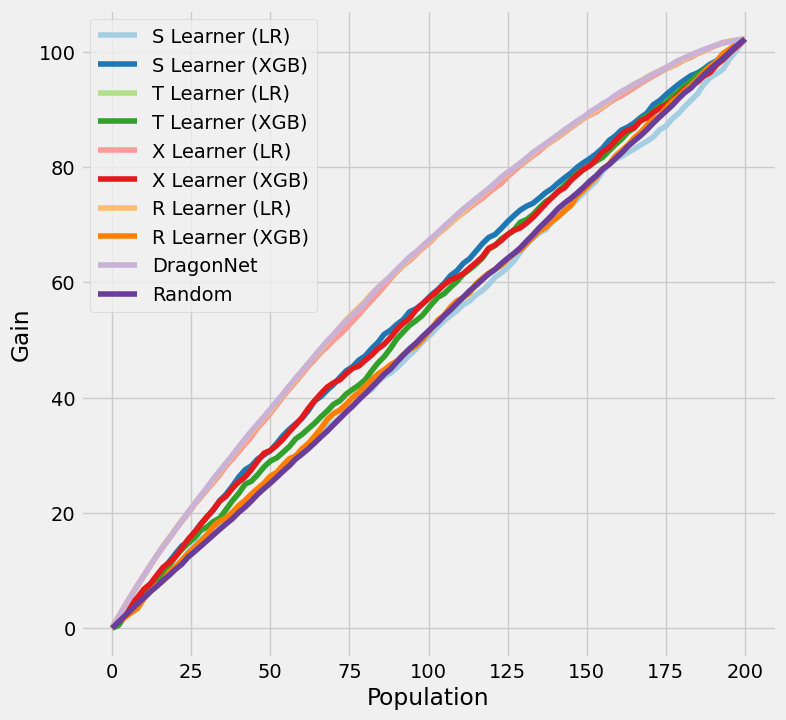

In [20]:
plot_gain(df_preds_validation)